## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Check imports

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [4]:
test_eq(TEST,'test')

In [5]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

## Get data

In [6]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [7]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/jupyter/.fastai/data/mnist.pkl.gz')

And then we can use the standard library gzip to open it and then we can pickle.load() it. So in Python the kind of standard serialization format is called pickle, and so this MNIST version on deeplearning.net is stored in that format, so it basically gives us a tuple of tuple of datasets like so:

In [8]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

It actually contains numpy arrays, but numpy arrays are not allowed in our foundations. So we have to convert them into tensors. So we can just use the Python map to map the tensor function over each of these four arrays, so we get back four tensors.

A lot of you will be more familiar with numpy arrays than PyTorch tensors, but you know, everything you can do in numpy arrays you can also do in PyTorch tensors, but you can also do it on the GPU and have all this nice deep learning infrastructure. So it is a good idea to get used to using PyTorch tensors in my opinion.

So we can now grab the numbers of rows and number of columns in the training set and we can take a look.

In [9]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

So here's MNIST, hopefully pretty familiar to you already. It is 50000 rows by 784 columns (28px x 28px), and the y data looks something like this: the y_shape is just 50000 rows and the minimum and maximum of the dependent variable is 0 - 9. Hopefully that looks pretty familiar.

So let's add some tests:

In [10]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [11]:
mpl.rcParams['image.cmap'] = 'gray'

In [12]:
img = x_train[0]

In [13]:
img.view(28,28).type()

'torch.FloatTensor'

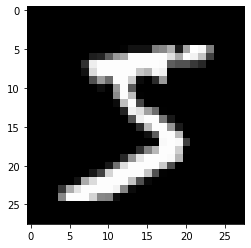

In [14]:
plt.imshow(img.view((28,28)));

So we got a FloatTensor and we pass that to imshow() after casting it to a 28 by 28. .view() is really important, I think we saw it a few times in part one, but get really familiar with it this is how we reshape our 784 long vector into a 28 by 28 matrix that is suitable for plotting.

Ok, so there's our data. And let's start by creating a simple linear model.
So for a linear model we are going to need to basically have something where y = ax + b and so our a will be a bunch of weights, so it is needs to be a 784 by 10 matrix, because we got 784 coming in and 10 coming out. That is going to allow us take in our independent variable and map it to something which we can compare to our dependent variable. And for our bias we just start with 10 zeroes.

## Initial python model

In [15]:
weights = torch.randn(784,10)

In [16]:
bias = torch.zeros(10)

So if we are going to do y = ax + b then we need a matrix multiplication. 

matrixmultiplication.xy shows us exactly what happens when we multiply two matrices.

So we need three loops.
And notice that this is not going to work unless the number of columns in the first matrix and the number of columns in the second matrix are the same. So let's grab the number of rows and columns of a (ar, ac) and the number of rows and columns of b (br,bc) and make sure that ac==br just to double check. 

And then let's create something of size ar by bc because the size of this is going to be ar by bc. Put zeroes in (`c = torch.zeros(ar, bc)`).

And have our three loops and then right in the middle, let's do that.
So right in the middle the result in i,j is going to be a[i,k] by b[k,j]. And this is the vast majority of what we are going to be doing in deep learning. So get very very comfortable with that equation:

`c[i,j] += a[i,k] + b[k,j]`

And it has got a few interesting things going on.<br>
The i here (in c) appears also over here (in a).<br>
This j here (in c) appears also over here (in b).<br>
And then the k in the loop appears twice.<br>
And look it is got to be the same number in each place because this is the bit where we are multiplying together the element wise things. So there it is.


#### Matrix multiplication

In [17]:
def matmul(a,b):
    ar,ac = a.shape    # n_rows * n_cols
    br,bc = b.shape
    assert ac==br                          # make sure matrices can be multiplied
    c = torch.zeros(ar, bc)                # init c to zeros with correct shape
    for i in range(ar):                    # n_rows of a
        for j in range(bc):                # n_cols of b
            for k in range(ac):            # n_cols of a, or n_rows of b
                c[i,j] += a[i,k] * b[k,j]  # update c
    return c

In [18]:
m1 = x_valid[:5]    # first 5 from valid set
m2 = weights        # torch.randn(784,10)

In [19]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [20]:
%time t1=matmul(m1, m2)

CPU times: user 884 ms, sys: 0 ns, total: 884 ms
Wall time: 891 ms


In [21]:
t1.shape

torch.Size([5, 10])

This is kinda slow - 1 sec per multiplication would be 50,000 sec for each pass of our dataset.<br>
This is why things are not written in python.

In [22]:
len(x_train)

50000

What if we could speed it up by 50,000 times? Let's try!

So the way we speed things up is, we start in the inner most loop and we make each bit faster. So the way to make Python faster, is to remove Python. And the way we remove Python is by passing our computation down to something that is written in something other than Python, like PyTorch. 

Because PyTorch behind the scenes is using something like a library called A10. So we want this to get this going down to the A10 library. So the way to do that is to use something like elementwise operations.

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [23]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [24]:
a + b

tensor([12., 14.,  3.])

In [25]:
(a < b).float().mean()

tensor(0.6667)

In [26]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

In [27]:
(m*m).sum().sqrt()

tensor(16.8819)

It is a matrix times itself, dot sum, dot square root.

So here's the first time we are going to start trying to translate some equations into code to help us understand these equations.

$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$ 

says when you see something like $A$ with two sets of double lines around it and an $_F$ underneath, that means: we are calculating the Frobenius norm. When you see this, what it actually means is this function $\left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

As you probably know capital sigma $\sum$ means sum. And $\sum_{i,j=1}^n$ says we are going to sum over two for loops. The first for loop will be called $i$ and we will go from $1$ to $n$. <br> 
And the second for loop will be called $j$ and will also go from $1$ to $n$. <br> 
And then in these nested for loops, we are going to grab something out of a matrix $a$ at position $_{i,j}$, we are going to square it $^2$ and then we are going to add all of those together $\sum{}$ and then we are going to take the square root $^{1/2}$.

Which is: `(m*m).sum().sqrt()`

#### Elementwise matmul

So this is all the same (the first 7 lines). But now we have replaced the inner loop and you'll see that basically it loks exactly the same as before but where it used to say k it now says :. 

So in PyTorch and numpy : means the entirity of that axis. So Rachel help me remember the order of rows and columns when we talk about matrices, which is the song 'Row by column, row by column'. So i is the row number, take all cloumns (a[i,:]). And this (b[:,j]) is column number j, take all rows. So multiply all of column j by all of row i and that gives us back a rank one tensor, which we add up. 

Ok, that is exactly the same as what we had before. So now that takes 1.45ms. We have removed one line of code and it is a 178 times faster.

In [28]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

`c[i]` is the same as `c[i,:]`. Any time there's a trailing colon in numpy or PyTorch, you can delete it optionally. You don't have to. 

`c[None,:]` is the same as `c[None]`

In [29]:
%timeit -n 10 _=matmul(m1, m2)

1.21 ms ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
890.1/5

178.02

So we successfully got rid of that inner loop. So now this is running in C. We didn't really write Python here, we wrote kind of a pythonicish thing that said: please call this C code for us. And that made it a 178 times faster.

Let's check that it is right. We cannot really check that it is equal, because Floats are sometimes changed slightly on how you calculate them, so instead let's create something called near() which calls torch.allclose() with some tolerance, and then we create a test_near() function that calls our test function using our near() comparison.

In [31]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [32]:
test_near(t1,matmul(m1, m2))

Now let's get rid of another loop...

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

Remember our tensor a which contains 10, 6., -4. If you say a > 0 then on the left hand side you got a rank one tensor, on the right hand side you got a scalar, and yet somehow it works. And the reason why is this value 0 is broadcast three times. It becomes 0,0,0 and then it does an elementwise comparison.
So every time for example you've normalised a dataset by subtracting the mean and divided by the standard deviation in a kind of one line like this (a > 0) you've actually been broadcasting. You've been broadcasting a scalar to a tensor.

In [33]:
a

tensor([10.,  6., -4.])

In [34]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [35]:
a + 1

tensor([11.,  7., -3.])

In [36]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [37]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [38]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [39]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [40]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [41]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

10,20,30 + 1,2,3. 10,20,30 + 4,5,6. 10,20,30 + 7,8,9. It broadcasts this row (10,20,30) across each row of the matrix. And it is doing that at C speed. So this (m + c) is no loop, but it sure looks as if there was a loop.

c + m does exactly the same thing.

In [42]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

So we can write c.expand_as(m) and it shows us what c would look like when broadcast to m. 10,20,30, 10,20,30, 10,20,30. So you can see m + t is the same as c + m.

In [43]:
t = c.expand_as(m)

In [44]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [45]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

Now you might be worrying though that this looks pretty memory intensive, if we are turning all of our rows into big matrices, but it is not. Because you can look inside the actual memory used by PyTorch.
So here t is a three by three matrix, but t.storage() tells us that actually it is only storing one copy of that data.

In [46]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

t.shape tells us that t knows it is meant to be a 3x3 matrix. And t.stride() tells us that it knows that when it is going from column to column to column, it should take one step through the storage. But when it goes from row to row, it should take 0 steps. So that how come it repeats 10,20,30, 10,20,30, 10,20,30. So this is a really powerful thing that appears in pretty much every linear algebra library you will come across, which is this idea that you can actually create tensors, that behave like higher rank things than as what they're actually stored as. So this is really neat. It basically means that this broadcasting functionally gives us C like speed with no additional memory overhead.

In [47]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [48]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [49]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [50]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

So c.unsqueeze(0) is of shape 1, 3. It puts the new dimension in position 1 (index 0).

unsqueeze(1) is shape 3, 1. It creates a new axis in position 2 (index1 ).

So unsqueeze(0) looks a lot like c, but now rather than being a rank one tensor, it is now a rank two tensor. See how it got two square brackets around it? See how it's size is 1, 3?

Perhaps more interestingly, c.unsqueeze(1) now looks like a column. It is also a rank two tensor, but it's three rows by one column.

---
Writing `.unsqueeze()` is kind of clunky, so PyTorch and numpy have a neat trick, which is that you can index an array with a special value `None`. 

And `None` means: squeeze a new axis in here please. So you can see that `c[None, :]` is exactly the same shape 1, 3 as `c.unsqueeze(0)`. And `c[:,None]` is exactly the same shape as `c.unsqueeze(1)`. So I hardly ever use unsqueeze until I particularly am trying to demonstrate something for teaching purposes. I pretty much always use None. Apart from anything else, I can add additional axis this way (`c[None, None, :]`) where with unsqueeze you need to do unsqueeze, unsqueeze, unsqueeze. So this is handy.

In [51]:
c.shape, c[None].shape, c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

**You can always skip trailling '`:`'s <br>
And `...` means 'all preceding dimensions'**

In [52]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [53]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [54]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [55]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [56]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

So basicaly what's happening is when we broadcast it is taking the thing which has a unit axis and it is kind of effectively copying that unit axis so it is as long as the larger tensor on that axis. But it doesn't really copy it, it just pretends as if it is being copied.

So we can use that to get rid of our loop. So this was the loop we were trying to get rid of (`for j in range(bc)`). Going through each of range(bc). 

And so here it is:

#### Matmul with broadcasting

In [57]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
    return c

So we are going to set the whole of row i of c (`c[i]`) to the whole of row i of a (`a[i]`) and then now that we got row i of a that is a rank one tensor. So let's turn it into a rank two tensor: (`a[i].unsqueeze(-1)`) We could also have written it like that (`a[i, None]`)
So this is now of length `ar` by 1, which is a rank two tensor. b is also a rank two tensor, and that is the entirity of our matrix.

And so `a[i].unsqueeze(-1)` is going to get broadcast over this `b`. Which gets rid of the loop.

This is actually going to return a rank two tensor. And then that rank to tensor we want to sum it up over the rows `sum(dim=0)`.

In [58]:
%timeit -n 10 _=matmul(m1, m2)

225 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
885000/277

3194.945848375451

It's faster, and still gives us the same results

In [60]:
test_near(t1, matmul(m1, m2))

And it is not just speed, once you get used to this kind of coding, getting rid of these loops I find really reduces a lot of errors in my code. It takes a while to get used to, but once you get used to it is a really comfortable way of programming.

#### Broadcasting Rules

Once you get to kind of higher ranked tensors, this broadcasting can get a bit complicated, so what you need to do instead of trying to keep it all in your head, is apply these simple broadcasting rules (same rules apply to numpy, PyTorch, TensorFlow, ...):

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. <br> 
<font color=red>It starts with the ****trailing dimensions****, and works its way forward.</font>

Two dimensions are ***compatible*** when

- **they are equal, or**
- **one of them is 1, in which case that dimension is broadcasted to make it the same size**
- **they don't have to be the same rank**
    - Anywhere there's a missing dimension, it treats it as a '1'

For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3
    
The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

In [61]:
c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [62]:
c[None,:], c[None,:].shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [63]:
c[:,None], c[:,None].shape

(tensor([[10.],
         [20.],
         [30.]]), torch.Size([3, 1]))

In [64]:
# Elementwise multiplication

c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [65]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

`c[i,j] += a[i,k] + b[k,j]` would be `ik,kj->ij` in einstein notation. <br>
*Each letter represents a dimension.

In [66]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [68]:
%timeit -n 10 _=matmul(m1, m2)

61.7 µs ± 7.91 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
885000/55

16090.90909090909

In [ ]:
test_near(t1, matmul(m1, m2))

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

Jeremy's explanation:<br>
So currently, to get a fast matrix multiply, things like PyTorch, they don't even write it themselves, they push it off to something called a blas. BLAS is a basic linear algebra subprogams library, where companies like Intel and AMD and Nvidia, write these things for you. So you can look up somethign like cuBLAS, this is like Nvidias version of BLAS. Or you can look up MKL, and this is like Intels version of BLAS. And this is kind of awful, because the programmer is limited to this subset of things that your BLAS can handle. And to use it you don't really get to write it in Python. You kind of have to write the one thing that happens to be turned into that existing BLAS call. So this is why we need to do better. And there are people working on this, and there are people actually in Chris Lattner's team working on this. There's really cool stuff, something called tensor comprehensions, which is origanlly came in PyTorch and I think they now are inside Chris' team in Google, where people are basically saying: here are ways to compile these much more general things. And this is what we want as more advance practitioners.

In [71]:
%timeit -n 10 t2 = m1.matmul(m2)

8.59 µs ± 5.19 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
# time comparison vs pure python:
885000/18

49166.666666666664

In [73]:
t2 = m1@m2        # This is calling the same code as m1.matmul(m2)

In [74]:
test_near(t1, t2)

In [75]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
m3,m4  = m1.cuda(),m2.cuda()

In [ ]:
t3 = m3.matmul(m4)

In [ ]:
%timeit -n 10 t3 = m3.matmul(m4)

23.9 µs ± 3.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Export

In [76]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
